# FANTASY Tutorial


Open source code FANTASY (Fully Automated pythoN tool for AGN Spectra analYsis) is a python based code for simultaneous multi-component fitting of AGN spectra, optimized for the optical rest-frame band (3600-8000A), but also applicable to the UV range (2000-3600A) and NIR range (8000-11000A). 

The code fits simultaneously the underlying broken power-law continuum and sets of defined emission line lists. There is an option to import and fit together the Fe II model, to fully account for the rich emission of complex Fe II ion which can produce thousands of line transitions, both in the range of Hg and Hb, but also Ha line. The Fe II model is based on the atomic parameters of Fe II, and builds upon the models presented in Kovacevic et al. 2010, Shapovalova et al. 2012, and assumes that different Fe II lines are grouped according to the same lower energy level in the transition with line ratios connected through the line transition oscillatory strengths. 

The code is flexible in the selection of different groups of lines, either already predefined lists (e.g., standard narrow lines, Hydrogen lines, Helium lines, other broad lines, forbidden Fe II lines, coronal lines, etc.), but gives full flexibility to the user to merge predefined line lists, create customized line list, etc. The code can be used either for fitting a single spectrum, as well as for the sample of spectra, which is illustrated in several given examples. It is an open source, easy to use code, available for installation through pip install option. It is based on sherpa python package (Burke et al. 2019).

In [1]:
#Before starting, we call some of the standard python packages, such as matplotlib, pandas, numpy, etc. 
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

import numpy as np
import pandas as pd

import glob

<font size=4> 1. Reading data </font>

First step involves reading a spectrum or set of spectra. We designed integrated three spectral classes: 
- read_sdss -  designedto read SDSS fits (https://www.sdss.org)
- read_gama_fits - designed to read GAMA fits (http://www.gama-survey.org)
- read_text - designed to read any ASCII files (e.g., wavelength, flux, flux_error)

The user has the possible to read any other file format using prefered method.

In [2]:
# Below command import the above mentioned reading commands
from fantasy_agn.tools import read_sdss, read_text, read_gama_fits

# Below command import the necessary commands, which will be described later
from fantasy_agn.models import create_input_folder

from fantasy_agn.models import create_feii_model, create_model, create_tied_model, continuum, create_line, create_fixed_model

In [4]:
# This command reads the spectrum with the listed name, from the folder of this notebook or 
# from the given path e.g.,'/path/to/files/spec*.txt'

s=read_sdss('/home/yukawa/Downloads/spec-2770-54510-0433.fits')

# Reading all .txt files with "spec" in the name
# file_list=glob.glob('/path/to/files/spec*.txt')

<font size="4"> 2. Prepartion of the spectra </font> 

Before performing the fittings, the FANTASY code provide several preprocessing options to prepare the spectrum, namely: 
- Galactic extinction correction - *DeRedden()*
- redshift correction - *CorRed()*
- host-galaxy fitting and subtraction - *fit_host*
- croping/scaling of spectra - *crop(xmin,xmax)*

In [5]:
# DeRedden() command corrects for the Galactic extinction, based on coordinates of the object provided in the fits, 
# which will be automatically derived from dust map data from Schlegel, Finkbeiner and Davis (1998).
# If coordinates are not available you could manually insert them using simple commands s.ra=xxx.xxx, s.dec=xxx.xxx

# s.ra=29.519807539582 #example input of arbitrary rightascension
# s.dec=-0.872742349310271 #example input of arbitrary declination

s.DeRedden()

In [6]:
# CorRed() corrects for the cosmological redshift, based on redshift of the object provided in the fits.
# If coordinates are not available you could manually insert them using simple command s.z=x.xxx
# s.z=0.0804 #example input of arbitrary redshift

s.CorRed()

In [7]:
# Crop function cuts the spectrum in a set wavelength range, e.g., if you want to fit just one emission line or a certain wavelength range

s.crop(4000, 8000)

In [8]:
# Useful tip is to avoid using very small flux units.
# e.g., SDSS spectra are given in 1e-17 erg/s/cm2/A and these are already scaled within read_sdss()

#s.flux=s.flux*10**17

Number of galaxy components  4
Number of QSO components  4
Reduced chi square  6.465770908593817


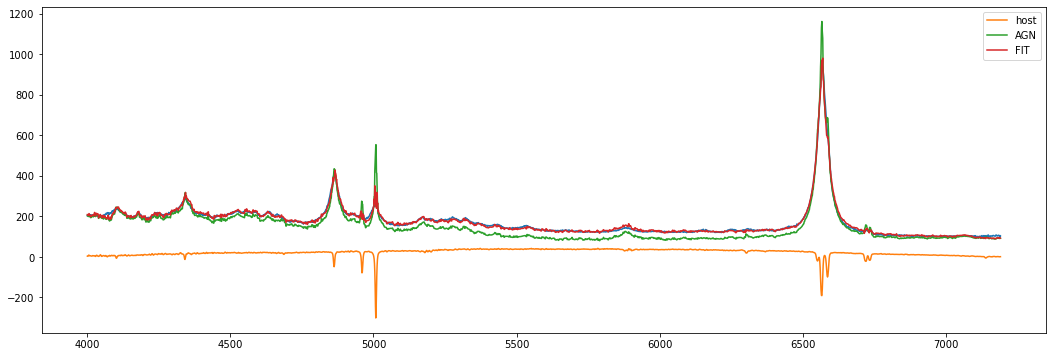

In [9]:
# Command *fit_host()* fits the observed spectrum with the combination of eignevectors for 
# the galaxy (stellar) and QSO components. The code will test for different number of components 
# until reaching best result based on the chi2 parameter.

# IMPPORTANT: Code will by default subtract the host galaxy from the observed spectrum; 
# if you need the original spectrum for some analysis, make sure to copy it before host fitting.
s.obs=s.flux

s.fit_host()

One possibility is to

Number of galaxy components  3
Number of QSO components  12
Reduced chi square  14.743762729510756


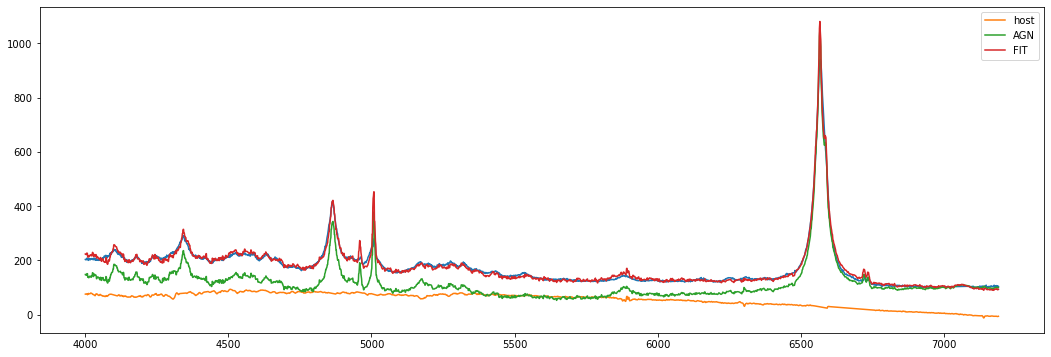

In [10]:
s.restore() #command to restore the spectrum before host galaxy fitting and substraction
s.host1=s.host
s.fit_host(mask_host=True, custom=False)

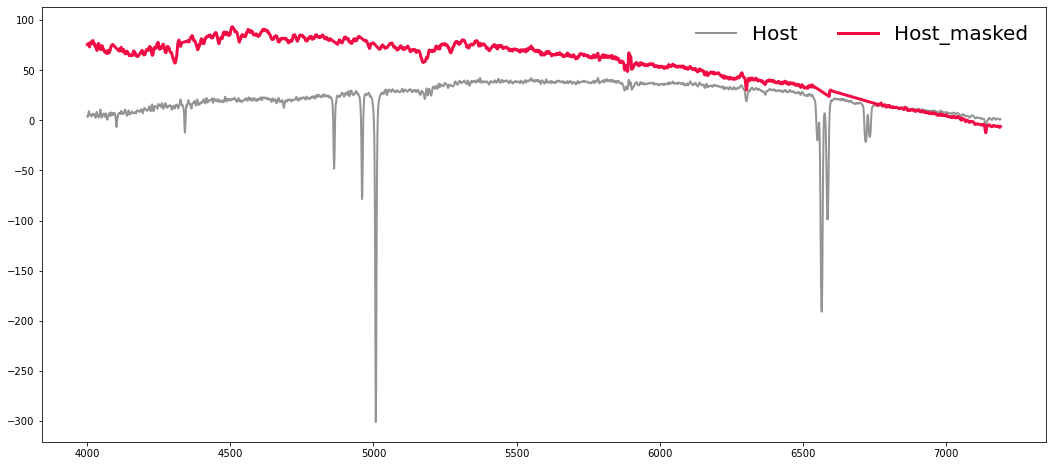

In [11]:
#Let's compare two host results.

plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
#plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, s.host1, color="#929591", label='Host', lw=2)
plt.plot(s.wave, s.host, color="#F10C45",label='Host_masked',lw=3)
plt.legend(loc='upper right',  prop={'size': 20}, frameon=False, ncol=2)




<font size="4"> 3. Creation of the predefined lists of emission lines </font> 

Within FANTASY there are some standard lists of AGN emission lines, such as: Hydrogen lines (e.g., Ha, Hb, Hg, Hd, Pa, Pb, Pg, Pd), Helium lines (both He I and He II), basic narrow lines ([OIII], [NII]), other AGN narrow lines, other AGN broad lines, Fe II lines, coronal lines, etc. 

The command create_input_folder(xmin,xmax,path_to_folder) creates a folder in the specified path, copies the predefined line lists within the specified wavelength range.

IMPORTANT: If the folder already exsists, it will be overwritten, which can be avoided by using the parameter overwrite='False'.

TIP: Users can extend/shorten these line lists, as well as create completly new ones.

In [14]:
create_input_folder(xmin=4000,xmax=8000, path_to_folder='/home/yukawa/test/',overwrite='True')

Directory  /home/yukawa/test/  already exists


<font size="4"> 4. Defining the fitting model </font> 

Basic and simple model for AGN spectra fittings, should contain:
- underlying continuum (broken power-law, power-law, streight line)
- emission line (narrow, broad)

Depending on the wavelength range, spectral quality (S/N ratio, spectra resolution), and object type, the fitting model can be customized to contain many and complex emission features. One example for a typical type 1 AGN is given here.

Below we describe the fitting components: 
- *continuum()* - calls BrokenPowerlaw() model for a given breaking point (parameter *refer* indicate the breaking wavelength); note that the continuum amplitude is then automatically set based on the flux value at the breaking point;
- *create_fixed_model* - calls all lines from the indicated list have the same width and shift); user can specify common name for these lines (parameter *name*);
- *create_tide_model* - calls all lines are having width and shift tided to the reference line (typically [OIII] 5007 line); user can specify common name for these lines (parameter *prefix*);
- *create_feii_model* - calls for the FeII model, in which all iron lines have the same width and shift;

- *create_line* - calls single line at the given wavelength (parameter *position*), with possibility to set width (fwhm), shift (*offset*) and intensity (*ampl*);
- *create_model* - calls all lines from the indicated list, but no parameter is constrained;

For multi-line models, user can call a single line-list and many line-lists using the option files=['list1.csv','list2.csv'].


In [15]:
cont=continuum(s,min_refer=5790, refer=5800, max_refer=5810)
broad=create_fixed_model(['hydrogen.csv', 'helium.csv'], name='br',min_offset=0, max_offset=800)
narrow=create_tied_model(name='OIII5007',files=['narrow_basic.csv','hydrogen.csv'],prefix='nr', fwhm=1000,min_offset=0, max_offset=300, min_fwhm=900, max_fwhm=1200,fix_oiii_ratio=True, position=5006.803341, included=True,min_amplitude=0.2)
fe=create_feii_model(name='feii', fwhm=1000, min_fwhm=600, max_fwhm=2000, offset=0, min_offset=-3000, max_offset=3000)

In [16]:
# Code fits simultaneously all features.
model = cont+broad+narrow+fe

<font size="4"> 5. Fittings </font> 

Command *s.fit()* perform fittings of the spectrum, which is based on Python Sherpa package, with above defined model. Code offers the possibility to set the number of consequent fittings (option ntrial) to increase the convergence, given with the chi2, which is listed.

In [17]:
s.fit(model, ntrial=3)

stati 628370.1723813603
1 iter stat:  6819.550993702287
2 iter stat:  2241.6390910924965
3 iter stat:  1024.3799531028344


Congratulations, you are DONE! 

<font size="4"> 6. Plotting the results </font> 

You can plot the results using your favorite plotting style, an example is given below.

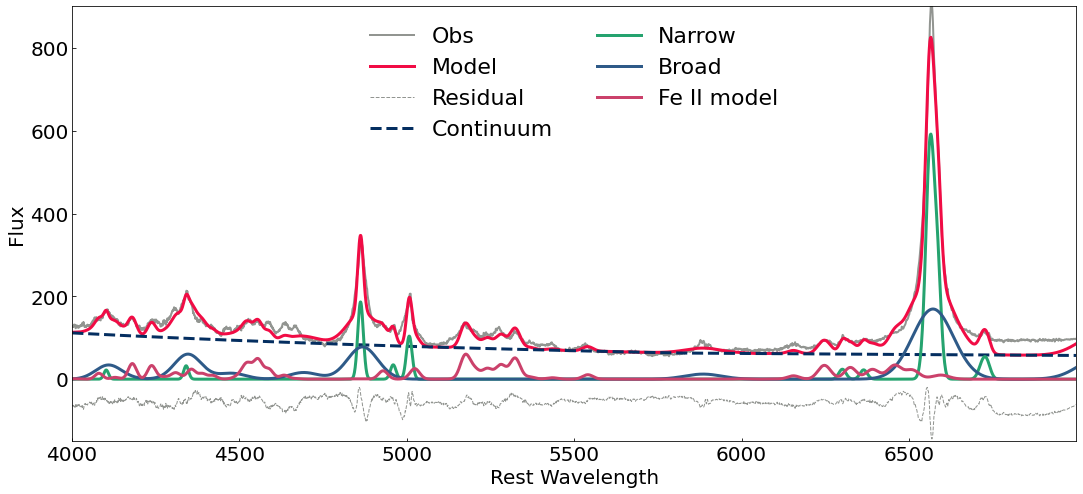

In [19]:
plt.style.context(['nature', 'notebook'])
plt.figure(figsize=(18,8))
plt.plot(s.wave, s.flux, color="#929591", label='Obs', lw=2)
plt.plot(s.wave, model(s.wave), color="#F10C45",label='Model',lw=3)
plt.plot(s.wave, model(s.wave)-s.flux-50, '--',color="#929591", label='Residual', lw=1 )


plt.plot(s.wave, cont(s.wave),'--',color="#042E60",label='Continuum', lw=3)
plt.plot(s.wave, narrow(s.wave),label='Narrow',color="#25A36F",lw=3)
plt.plot(s.wave, broad(s.wave), label='Broad', lw=3, color="#2E5A88")
plt.plot(s.wave, fe(s.wave),'-',color="#CB416B",label='Fe II model', lw=3)

plt.xlabel('Rest Wavelength',fontsize=20)
plt.ylabel('Flux',fontsize=20)
plt.xlim(4000,7000)
plt.ylim(-150,900)
plt.tick_params(which='both', direction="in")
plt.yticks(fontsize=20)
plt.xticks(np.arange(4000, 7000, step=500),fontsize=20)
plt.legend(loc='upper center',  prop={'size': 22}, frameon=False, ncol=2)

plt.savefig('fantasy_fit.pdf')

<font size="4"> 7.Inspecting/saving the plotting results </font> 

To examine the fitting results, simply use the command *model*, which will display all parameters for each emission line. Note that for complex model, for which the name/prefix has been indicated when defining the model.

In [20]:
model

<BinaryOpModel model instance '(((brokenpowerlaw + br) + (((((((((((((nr_OIII5007 + nr_OIII4958) + nr_NII6584) + nr_NIII6548) + nr_[O III]_4363) + nr_[O I]_6300) + nr_[O I]_6363) + nr_[S II]_6716) + nr_[S II]_6730) + nr_[O II]_7330) + nr_Hd_4101) + nr_Hg_4340) + nr_Hb_4861) + nr_Ha_6562)) + feii)'>

In [21]:
# To see the fitting results, one can use standard outputs from Sherpa package, such as:
# gres - to list all fitting results
# gres.parnames - to list all parameters
# save_json() - to save the results
s.gres

Parameter,Best-fit value,Approximate error
brokenpowerlaw.refer,5810,± 26.0748
brokenpowerlaw.ampl,63.1799,± 0.396833
brokenpowerlaw.index1,-1.52735,± 0.0138585
brokenpowerlaw.index2,1,± 0.0396013
br.amp_Hd_4102,32.5182,± 1.36654
br.amp_Hg_4340,60.4257,± 2.55835
br.amp_Hb_4861,77.9782,± 0.667277
br.amp_Ha_6563,169.399,± 1.14435
br.amp_HeI_4144,3.19896,± 0.882973
br.amp_HeI_4471,14.2359,± 0.520468


<font size="4"> 8. Simple analysis </font> 

Here we demonstrate how to measure the fluxes of a model component.

In [24]:
flux_feII=np.sum(fe(s.wave))
flux_Ha_broad=np.sum
print(flux_feII)


22742.078
